In [1]:
import cv2
import os
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import h5py

# 自動增長 GPU 記憶體用量
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
h5_base_dir = '../../../imagenet100/'
with h5py.File(os.path.join(h5_base_dir, 'x_train.h5'), 'r') as h5f:
    classes = list(h5f.keys())
num_classes = 20
classes = classes[:num_classes]

In [3]:
x_train = list()
y_train = list()
x_test = list()
y_test = list()
with h5py.File(os.path.join(h5_base_dir, 'x_train.h5'), 'r') as h5f:
    index = 0
    for cls in classes:
        x_train.append(h5f[cls])
        y = np.ndarray(x_train[-1].shape[0])
        y[:] = index
        y_train.append(y)
        index +=1
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)

with h5py.File(os.path.join(h5_base_dir, 'x_test.h5'), 'r') as h5f:
    index = 0
    for cls in classes:
        x_test.append(h5f[cls])
        y = np.ndarray(x_test[-1].shape[0])
        y[:] = index
        y_test.append(y)
        index +=1
    x_test = np.concatenate(x_test)
    y_test = np.concatenate(y_test)

In [4]:
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

In [5]:
input_shape = x_train.shape[1:]

In [6]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200

n = 2

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
    
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [14]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 kernel_regularizer=l2(1e-4),
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=kernel_regularizer)

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [15]:
def resnet_v1(input_shape, depth, num_classes=10, kernel_regularizer=l2(1e-4)):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, kernel_regularizer=kernel_regularizer)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             kernel_regularizer=kernel_regularizer,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             kernel_regularizer=kernel_regularizer,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 kernel_regularizer=kernel_regularizer,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
def resnet_v2(input_shape, depth, num_classes=10, kernel_regularizer=l2(1e-4)):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     kernel_regularizer=kernel_regularizer,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             kernel_regularizer=kernel_regularizer,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             kernel_regularizer=kernel_regularizer,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_regularizer=kernel_regularizer,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 kernel_regularizer=kernel_regularizer,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [11]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [16]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth, num_classes=num_classes, kernel_regularizer=l2(2e-4))
else:
    model = resnet_v1(input_shape=input_shape, depth=depth, num_classes=num_classes, kernel_regularizer=l2(2e-4))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)


Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
________________________________________________________________________

In [18]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [19]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
import datetime as dt
model_name = 'pmon_%s_%s_model.{epoch:03d}.h5' % (model_type, dt.datetime.now().strftime("%Y%m%d%H"))
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False)

In [20]:
callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [21]:
# Run training
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=callbacks)

Train on 16439 samples, validate on 4119 samples
Learning rate:  0.001
Epoch 1/200
16416/16439 [============================>.] - ETA: 0s - loss: 2.5323 - accuracy: 0.3350
Epoch 00001: saving model to /home/z99792458/nbs/detection_models_imagenet_100/resnet/saved_models/pmon_ResNet14v1_2020081507_model.001.h5
16439/16439 [==============================] - 71s 4ms/sample - loss: 2.5316 - accuracy: 0.3351 - val_loss: 2.2068 - val_accuracy: 0.4173
Learning rate:  0.001
Epoch 2/200
16416/16439 [============================>.] - ETA: 0s - loss: 1.8448 - accuracy: 0.5091
Epoch 00002: saving model to /home/z99792458/nbs/detection_models_imagenet_100/resnet/saved_models/pmon_ResNet14v1_2020081507_model.002.h5
16439/16439 [==============================] - 66s 4ms/sample - loss: 1.8444 - accuracy: 0.5092 - val_loss: 1.8059 - val_accuracy: 0.5251
Learning rate:  0.001
Epoch 3/200
16416/16439 [============================>.] - ETA: 0s - loss: 1.5657 - accuracy: 0.5853
Epoch 00003: saving model to

KeyboardInterrupt: 

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen.fit(x_train)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
validation_datagen.fit(x_test)

In [22]:
model.save_weights('./saved_models/pmon_%s_%s_model.%s.final.h5' % (model_type, dt.datetime.now().strftime("%Y%m%d%H"), '22.2e-4'))  # The third string parameter is the suffix string

In [ ]:
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import matplotlib.cbook as cbook 

plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.title('model accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.legend(['train', 'validation'], loc='upper left') 
plt.show()

# summarize history for loss 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'validation'], loc='upper left') 
plt.show() 

In [46]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

4119/4119 [==============================] - 5s 1ms/sample - loss: 1.8263 - accuracy: 0.6594
Test loss: 1.826332885537746
Test accuracy: 0.65938336


In [47]:
from sklearn.metrics import confusion_matrix 
from sklearn.utils.multiclass import unique_labels 
import matplotlib.pyplot as plt 

In [48]:
inferenced = model.predict(x_test) 

In [49]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues): 
    """ 
    This function prints and plots the confusion matrix. 
    Normalization can be applied by setting `normalize=True`. 
    """ 
    title = 'Confusion matrix, without normalization' if title is None else Title
    y_pred = np.argmax(y_pred.T, axis=0) 
    y_true = np.argmax(y_true.T, axis=0) 
    # Compute confusion matrix 
    cm = confusion_matrix(y_true, y_pred) 
    # Only use the labels that appear in the data 
    classes = classes[unique_labels(y_true, y_pred)] 

    fig, ax = plt.subplots(figsize=(15,15)) 
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap) 
    ax.figure.colorbar(im, ax=ax) 
    # We want to show all ticks... 
    ax.set(xticks=np.arange(cm.shape[1]), 
           yticks=np.arange(cm.shape[0]), 
           # ... and label them with the respective list entries 
           xticklabels=classes, yticklabels=classes, 
           title=title, 
           ylabel='True answer', 
           xlabel='Inference label') 
    # Rotate the tick labels and set their alignment. 
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
    # Loop over data dimensions and create text annotations. 
    fmt = 'd' 
    thresh = cm.max() / 2. 
    for i in range(cm.shape[0]): 
        for j in range(cm.shape[1]): 
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center",  color="white" if cm[i, j] > thresh else "black") 
    fig.tight_layout() 

    return ax 

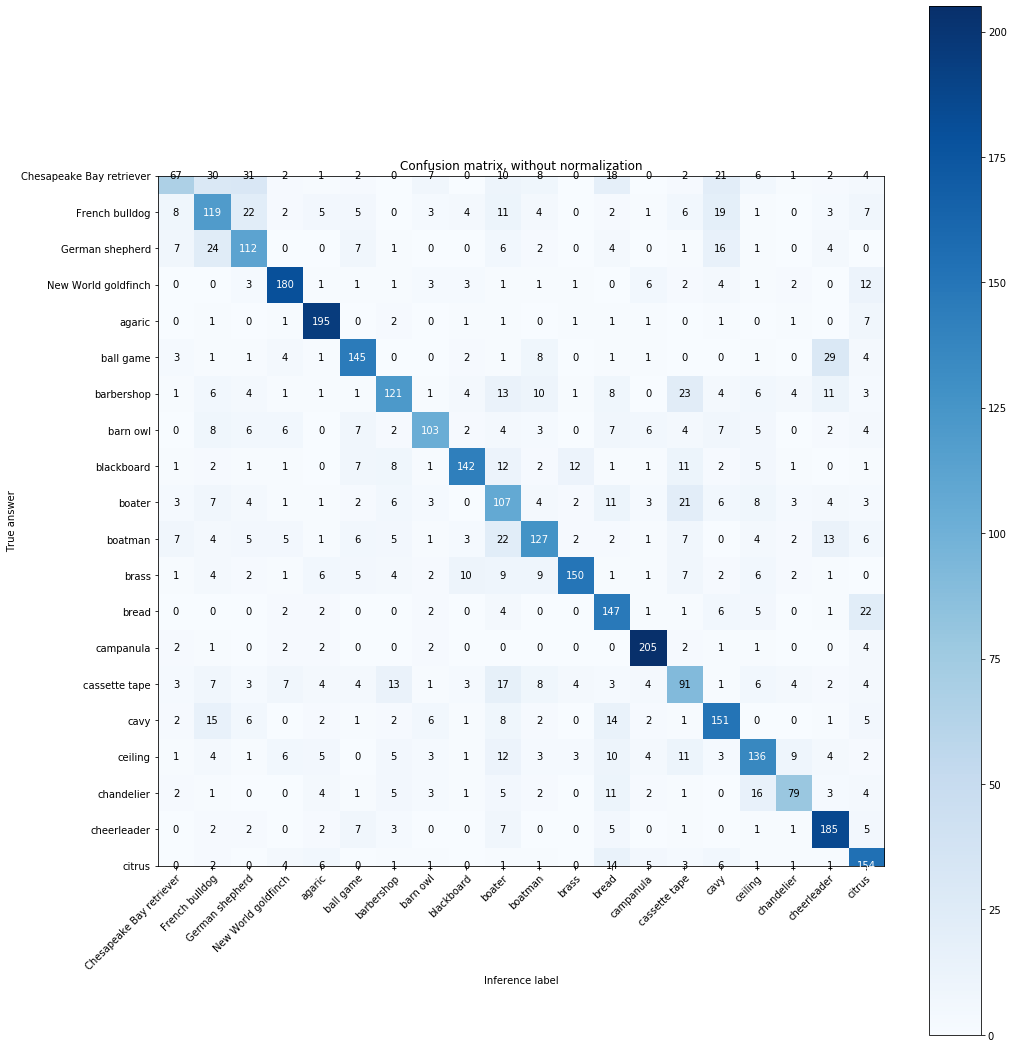

In [50]:
plot_confusion_matrix(y_test , inferenced, np.array(classes))

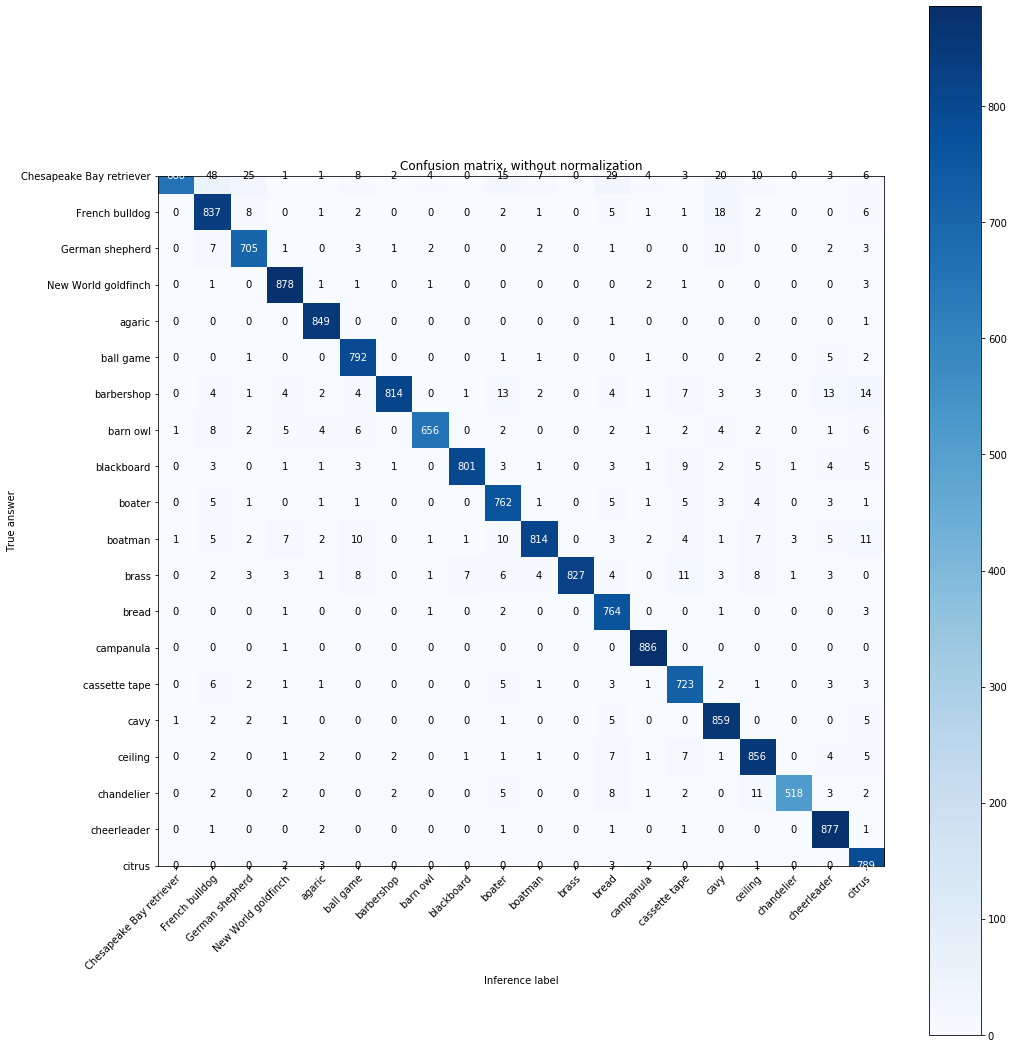

In [51]:
inferenced = model.predict(x_train) 
plot_confusion_matrix(y_train, inferenced, np.array(classes))